<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "PAL"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/BrainStructures/PAL/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


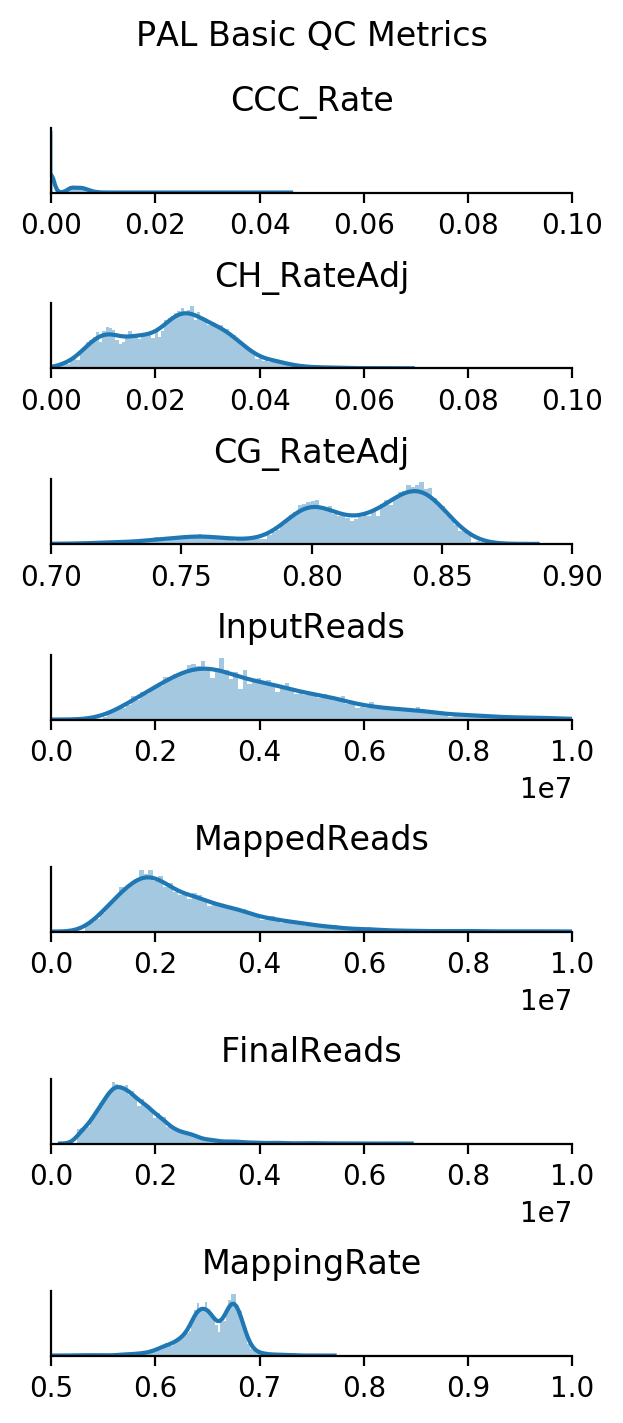

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

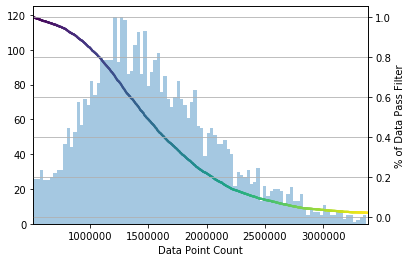

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 4703/4703 (100.0%)
CG_RateAdj passed 4703/4703 (100.0%)
CH_RateAdj passed 4703/4703 (100.0%)
FinalReads passed 4703/4703 (100.0%)
MappingRate passed 4703/4703 (100.0%)
Overall passed 4703/4703 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
180724 180
180806 711
180911 1196
181015 1350
181016 1266


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 595 154.9%
ad002 589 153.4%
ad004 594 154.7%
ad006 609 158.6%
ad007 616 160.4%
ad008 613 159.6%
ad010 547 142.4%
ad012 540 140.6%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
4H_M_0,/gale/raidix/rdx-4/CEMBA_RS1/4H/CEMBA_4H_Set_B...,0.00416,0.800830,0.800000,0.016100,0.011990,1912433.0,5029842,3437662.0,4H,...,3.864176,-16.452183,20.534164,-23.634229,D1L-Fstl4 Cadm1,10.191993,3.258994,4.146299,13.900548,True
4H_M_1,/gale/raidix/rdx-4/CEMBA_RS1/4H/CEMBA_4H_Set_B...,0.00708,0.830480,0.829270,0.039170,0.032320,1516215.0,3990068,2697119.0,4H,...,-11.931805,0.876655,-16.121507,30.396501,PAL-Inh Ptprd,7.590249,20.074369,32.077075,20.839314,True
4H_M_10,/gale/raidix/rdx-4/CEMBA_RS1/4H/CEMBA_4H_Set_B...,0.00320,0.741520,0.740690,0.008040,0.004860,3360625.0,9945770,6641181.0,4H,...,-4.363002,-10.081323,-1.500245,22.532884,ODC odc-large,-3.676983,5.729719,-5.490508,19.696834,True
4H_M_100,/gale/raidix/rdx-4/CEMBA_RS1/4H/CEMBA_4H_Set_B...,0.00580,0.838450,0.837510,0.032620,0.026980,2344229.0,6603910,4560638.0,4H,...,-11.897210,-0.136802,-8.373034,32.567110,PAL-Inh Ptprd,8.148896,18.559414,27.358427,20.833733,True
4H_M_1000,/gale/raidix/rdx-4/CEMBA_RS1/4H/CEMBA_4H_Set_B...,0.00283,0.740690,0.739950,0.004760,0.001940,1500717.0,3826894,2568877.0,4H,...,-0.758522,1.605597,-4.464463,40.078520,MGC mgc-all,2.968770,2.478164,8.001674,-6.757893,True
4H_M_1001,/gale/raidix/rdx-4/CEMBA_RS1/4H/CEMBA_4H_Set_B...,0.00517,0.833630,0.832770,0.029280,0.024240,2730818.0,8630770,5851093.0,4H,...,-7.930403,-0.129009,2.663973,16.096433,PAL-Inh Tcf7l2,1.590290,2.979156,-39.391078,20.970122,True
4H_M_1002,/gale/raidix/rdx-4/CEMBA_RS1/4H/CEMBA_4H_Set_B...,0.00378,0.792320,0.791530,0.014030,0.010290,2910227.0,9331122,6343649.0,4H,...,2.830655,0.010036,-25.620826,42.781708,Foxp2 Dchs2,2.157196,-3.201819,-2.218548,-3.282884,True
4H_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/4H/CEMBA_4H_Set_B...,0.00746,0.850600,0.849480,0.043650,0.036460,3371184.0,10802456,7369728.0,4H,...,-9.695090,-1.392110,-1.789236,26.822402,PAL-Inh Igdcc3,7.290937,14.986669,17.324252,-0.435187,True
4H_M_1004,/gale/raidix/rdx-4/CEMBA_RS1/4H/CEMBA_4H_Set_B...,0.00670,0.842820,0.841760,0.037420,0.030930,3673151.0,11803880,7915048.0,4H,...,-5.763227,-1.640050,7.808894,9.404146,PAL-Inh Meis2,10.218321,4.415151,-23.015785,-18.596209,True
4H_M_1005,/gale/raidix/rdx-4/CEMBA_RS1/4H/CEMBA_4H_Set_B...,0.00718,0.829980,0.828750,0.041980,0.035050,2160148.0,6976704,4716040.0,4H,...,-8.246440,-0.972078,-4.893546,17.802977,PAL-Inh Meis2,6.605491,5.029535,-7.714051,2.810438,True
